In [3]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20, pretrained=None):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True) # change for LSTM or RNN
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        self.pretrained = pretrained
        if self.pretrained:
            print(f'loading pretrained model: {pretrained}')
            weight = torch.load(self.pretrained)
            weight = weight.to(device)
            self.prembed = nn.Embedding.from_pretrained(weight, freeze=True)

    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        if self.pretrained:
            embeddings = self.prembed(captions).float()
        else:
            embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, pretrained=None, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            if pretrained:
                inputs = self.prembed(predicted).float()
            else:
                inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [5]:
import torch
import torch.nn as nn
import numpy as np
import os
import pickle
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms
from torch.utils.data import DataLoader
import wandb
from ipynb.fs.full.vocabulary_builder import Vocabulary
from ipynb.fs.full.data_loader import ROCODataset


wandb.init(project="image_captioning")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def main(model_name = 'EX1',
         model_path = 'models/',
         vocab_path = 'data/vocab.pkl',
         embed_size = 256,
         hidden_size = 512,
         num_layers = 1,
         num_epochs = 30,
         batch_size = 64,
         learning_rate = 0.001 ):
    model_path = os.path.join(model_path, model_name)
    # Create model directory
    if not os.path.exists(model_path):
        os.makedirs(model_path)
    
    # Image preprocessing, normalization
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    # Load vocabulary wrapper
    with open(vocab_path, 'rb') as f:
        vocab = pickle.load(f)

    train_dataset = ROCODataset(data_json='selected_dataset-60000/selected_dataset_60000_info.json',
                                transform=transform,
                                vocab=vocab,
                                dataset_type='train')
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,
                              collate_fn=ROCODataset.collate_fn,
                              num_workers=2)

    val_dataset = ROCODataset(data_json='selected_dataset-60000/selected_dataset_60000_info.json',
                              transform=transform,
                              vocab=vocab,
                              dataset_type='validation')

    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True,
                            collate_fn=ROCODataset.collate_fn,
                            num_workers=2)

    # Build the models
    encoder = EncoderCNN(embed_size).to(device)
    decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
    optimizer = torch.optim.Adam(params, lr=learning_rate)

    # Train the models
    def train(init_epoch=0):
        total_step = len(train_loader)
        
        train_losses = []
        val_losses = []
        prev_loss = -100
        loss_increase_counter = 0
        early_stop = True
        early_stop_threshold = 5

        for epoch in range(init_epoch, num_epochs):
            running_loss = 0.0
            for i, (images, captions, lengths) in enumerate(train_loader):

                # Set mini-batch dataset
                images = images.to(device)
                captions = captions.to(device)
                targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

                # Forward, backward and optimize
                features = encoder(images)
                outputs = decoder(features, captions, lengths)
                outputs = outputs
                loss = criterion(outputs, targets)
                decoder.zero_grad()
                encoder.zero_grad()
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item() * images.size(0)

                # Print log info
                wandb.log({"training loss": loss.item()})
                wandb.log({"Perplexity": np.exp(loss.item())})
                if i % 200 == 0:
                    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                          .format(epoch, num_epochs, i, total_step, loss.item(), np.exp(loss.item()))) 

            # Save the model checkpoints
            if (epoch+1) % 100 == 0:
                torch.save(decoder.state_dict(), os.path.join(
                    model_path, 'decoder-{}.ckpt'.format(epoch+1)))
                torch.save(encoder.state_dict(), os.path.join(
                    model_path, 'encoder-{}.ckpt'.format(epoch+1)))
            
            train_loss = running_loss/len(train_loader)
            train_losses.append(train_loss)
            val_loss = val()
            print(f'Validation Loss after Epoch [{epoch + 1}/{num_epochs}]: {val_loss:.4f}')
            val_losses.append(val_loss)
            
            if val_loss == min(val_losses):
                torch.save(decoder.state_dict(), os.path.join(
                    model_path, 'decoder-best.ckpt'))
                torch.save(encoder.state_dict(), os.path.join(
                    model_path, 'encoder-best.ckpt'))
            
            if val_loss > prev_loss:
                loss_increase_counter += 1
            else:
                loss_increase_counter = 0
            if early_stop and loss_increase_counter > early_stop_threshold:
                print("Early Stopping..")
                break
            prev_loss = val_loss
            
    def val():
        running_loss = 0.0
        for i, (images, captions, lengths) in enumerate(val_loader):
    
            images = images.to(device)
            captions = captions.to(device)
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
            
            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            outputs = outputs
            loss = criterion(outputs, targets)
            running_loss += loss.item() * images.size(0)
            wandb.log({"validation loss": loss.item()})
        return running_loss / len(val_loader)
    train()


if __name__ == '__main__':
    model_name = 'EX1'
    model_path = 'models/'
    vocab_path = 'vocab.pkl'
    embed_size = 256
    hidden_size = 512
    num_layers = 1
    num_epochs = 20
    batch_size = 64
    learning_rate = 0.001 

    main(model_name, model_path, vocab_path, embed_size, hidden_size, num_layers, num_epochs, batch_size, learning_rate)


Perplexity,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training loss,█▅▄▄▄▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▂▂▁▁▂▁▁▁▂▁▁▁
validation loss,▄▇▄▆▅▅▄▅▇▆▅▄▆▆▅▅▆█▃▄▇▅▅█▆▇▆▆▅▆▄▆▆▇▅▆▄▄▆▁
Perplexity,56.28738
training loss,4.03047
validation loss,3.62676


/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [0/20], Step [0/859], Loss: 9.5870, Perplexity: 14574.1635
Epoch [0/20], Step [200/859], Loss: 5.2059, Perplexity: 182.3528
Epoch [0/20], Step [400/859], Loss: 4.3380, Perplexity: 76.5508
Epoch [0/20], Step [600/859], Loss: 4.4433, Perplexity: 85.0555
Epoch [0/20], Step [800/859], Loss: 4.4039, Perplexity: 81.7674
Validation Loss after Epoch [1/20]: 265.2086
Epoch [1/20], Step [0/859], Loss: 4.2234, Perplexity: 68.2669
Epoch [1/20], Step [200/859], Loss: 3.7472, Perplexity: 42.4037
Epoch [1/20], Step [400/859], Loss: 3.8099, Perplexity: 45.1467
Epoch [1/20], Step [600/859], Loss: 3.9043, Perplexity: 49.6145
Epoch [1/20], Step [800/859], Loss: 3.7494, Perplexity: 42.4948
Validation Loss after Epoch [2/20]: 243.9966
Epoch [2/20], Step [0/859], Loss: 3.7202, Perplexity: 41.2720
Epoch [2/20], Step [200/859], Loss: 3.6100, Perplexity: 36.9672
Epoch [2/20], Step [400/859], Loss: 3.6225, Perplexity: 37.4299
Epoch [2/20], Step [600/859], Loss: 3.5422, Perplexity: 34.5421
Epoch [2/20], St

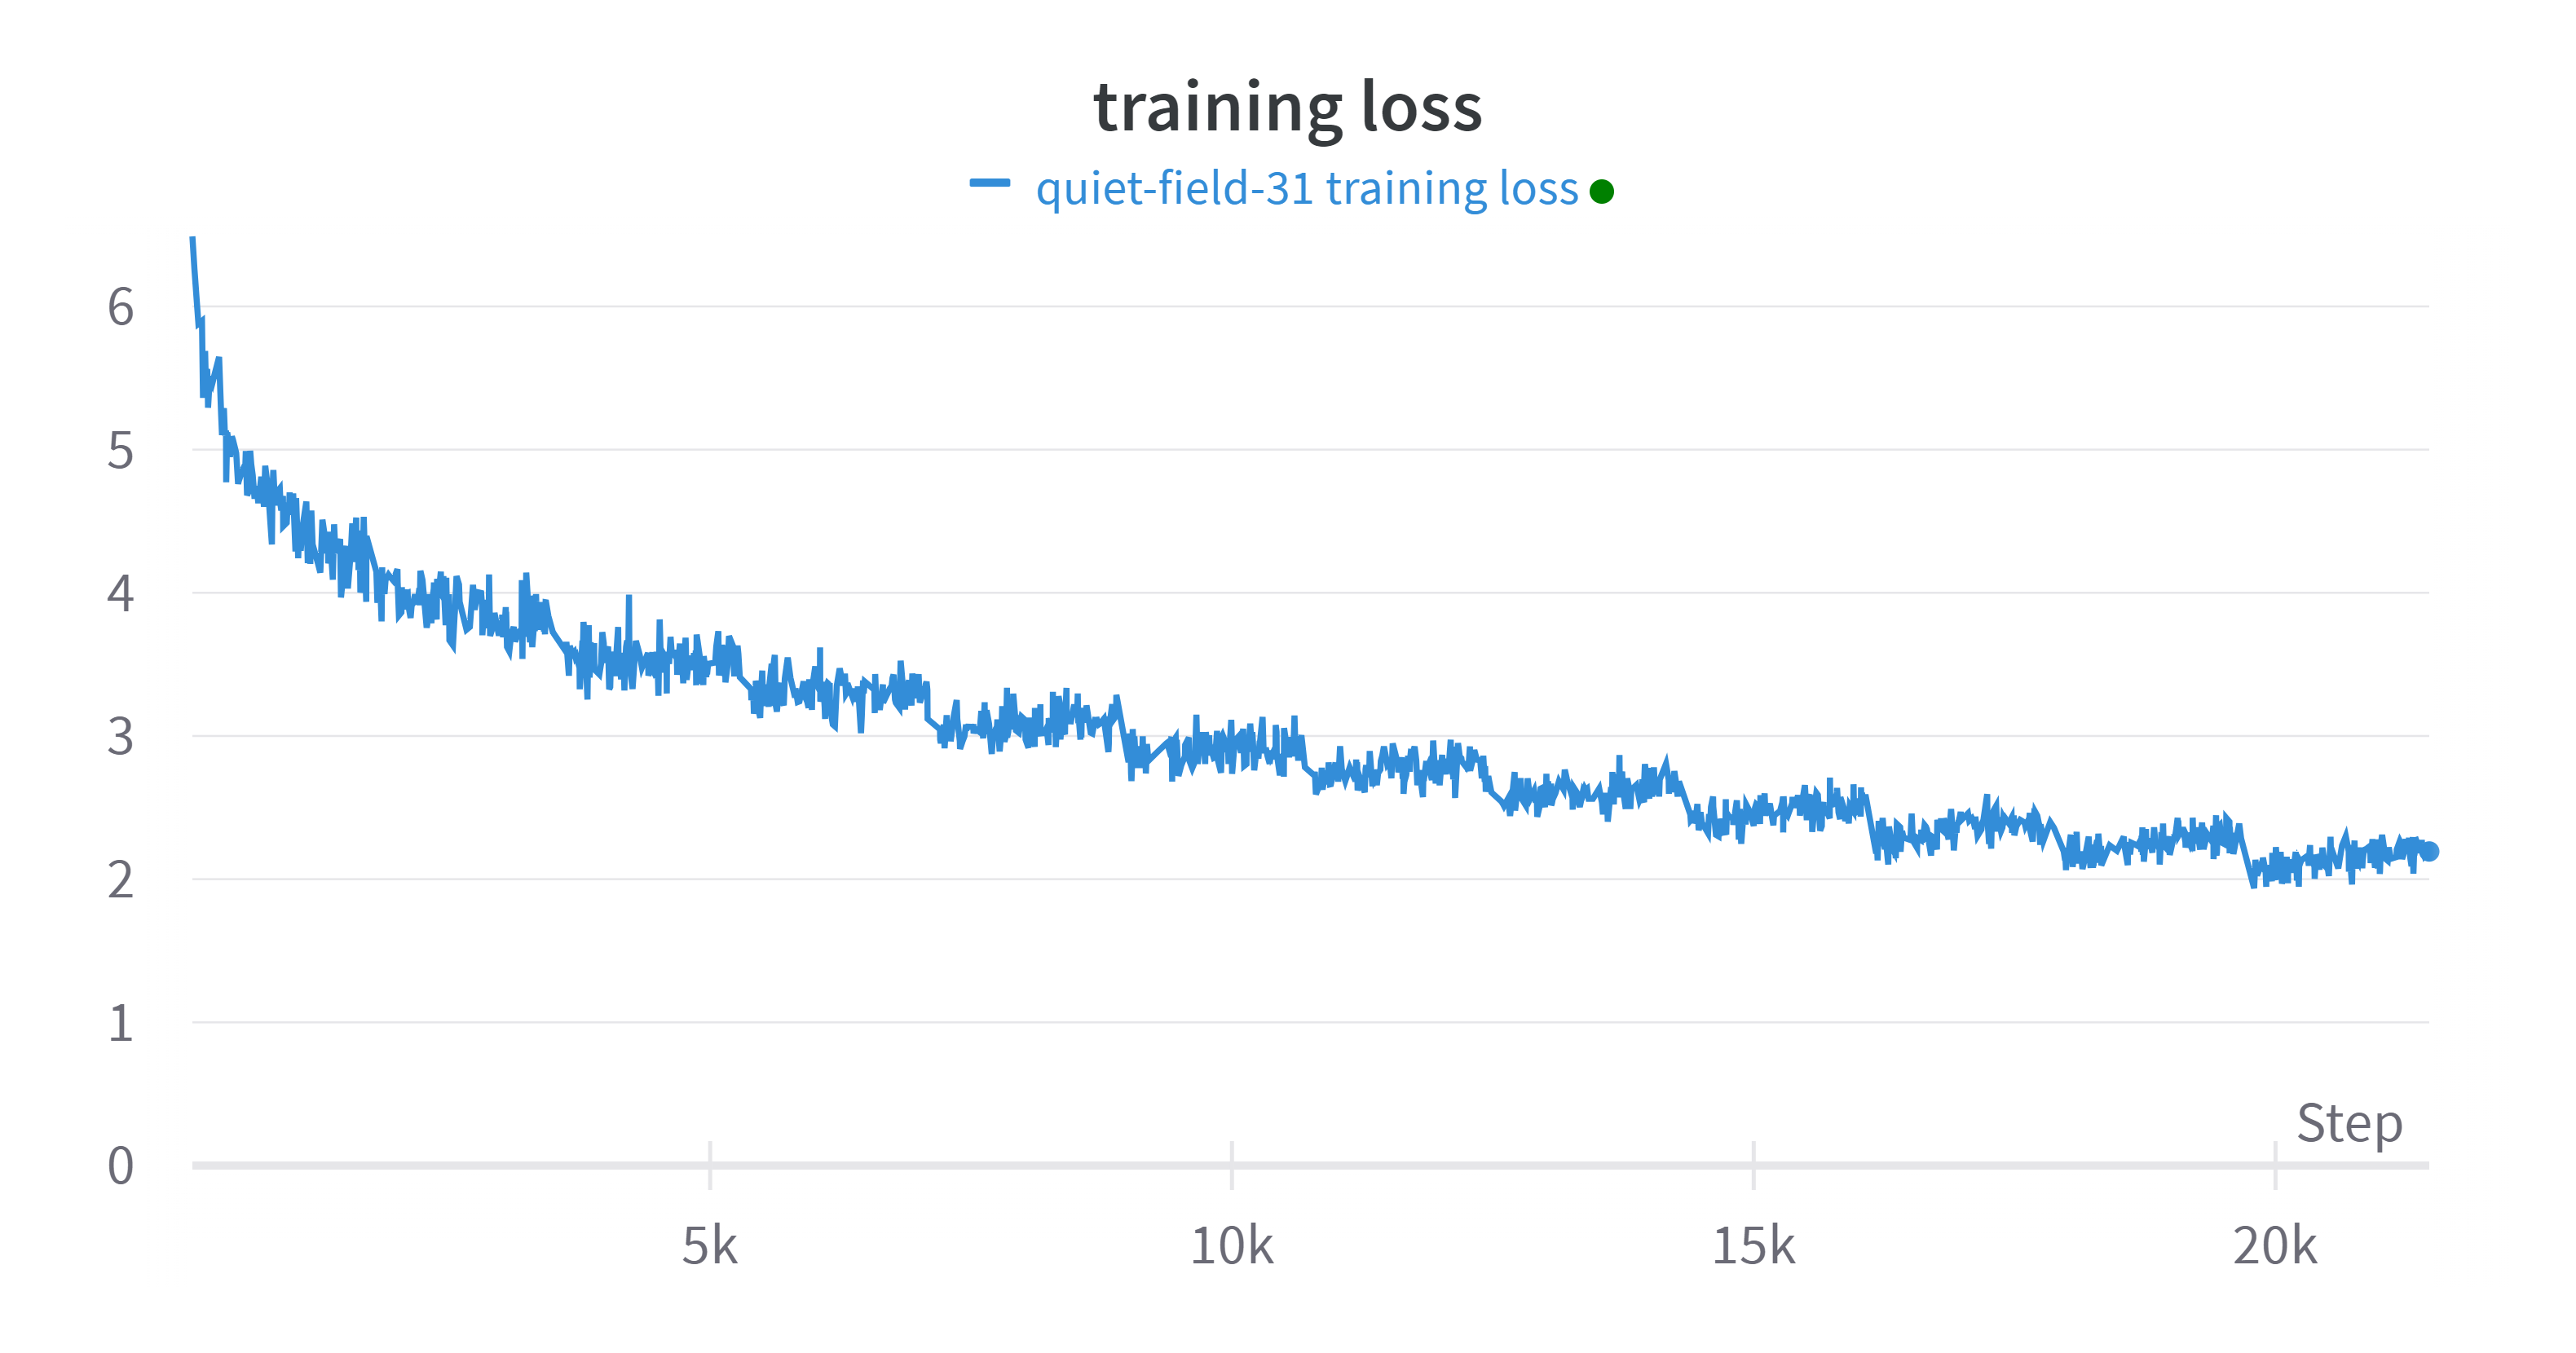

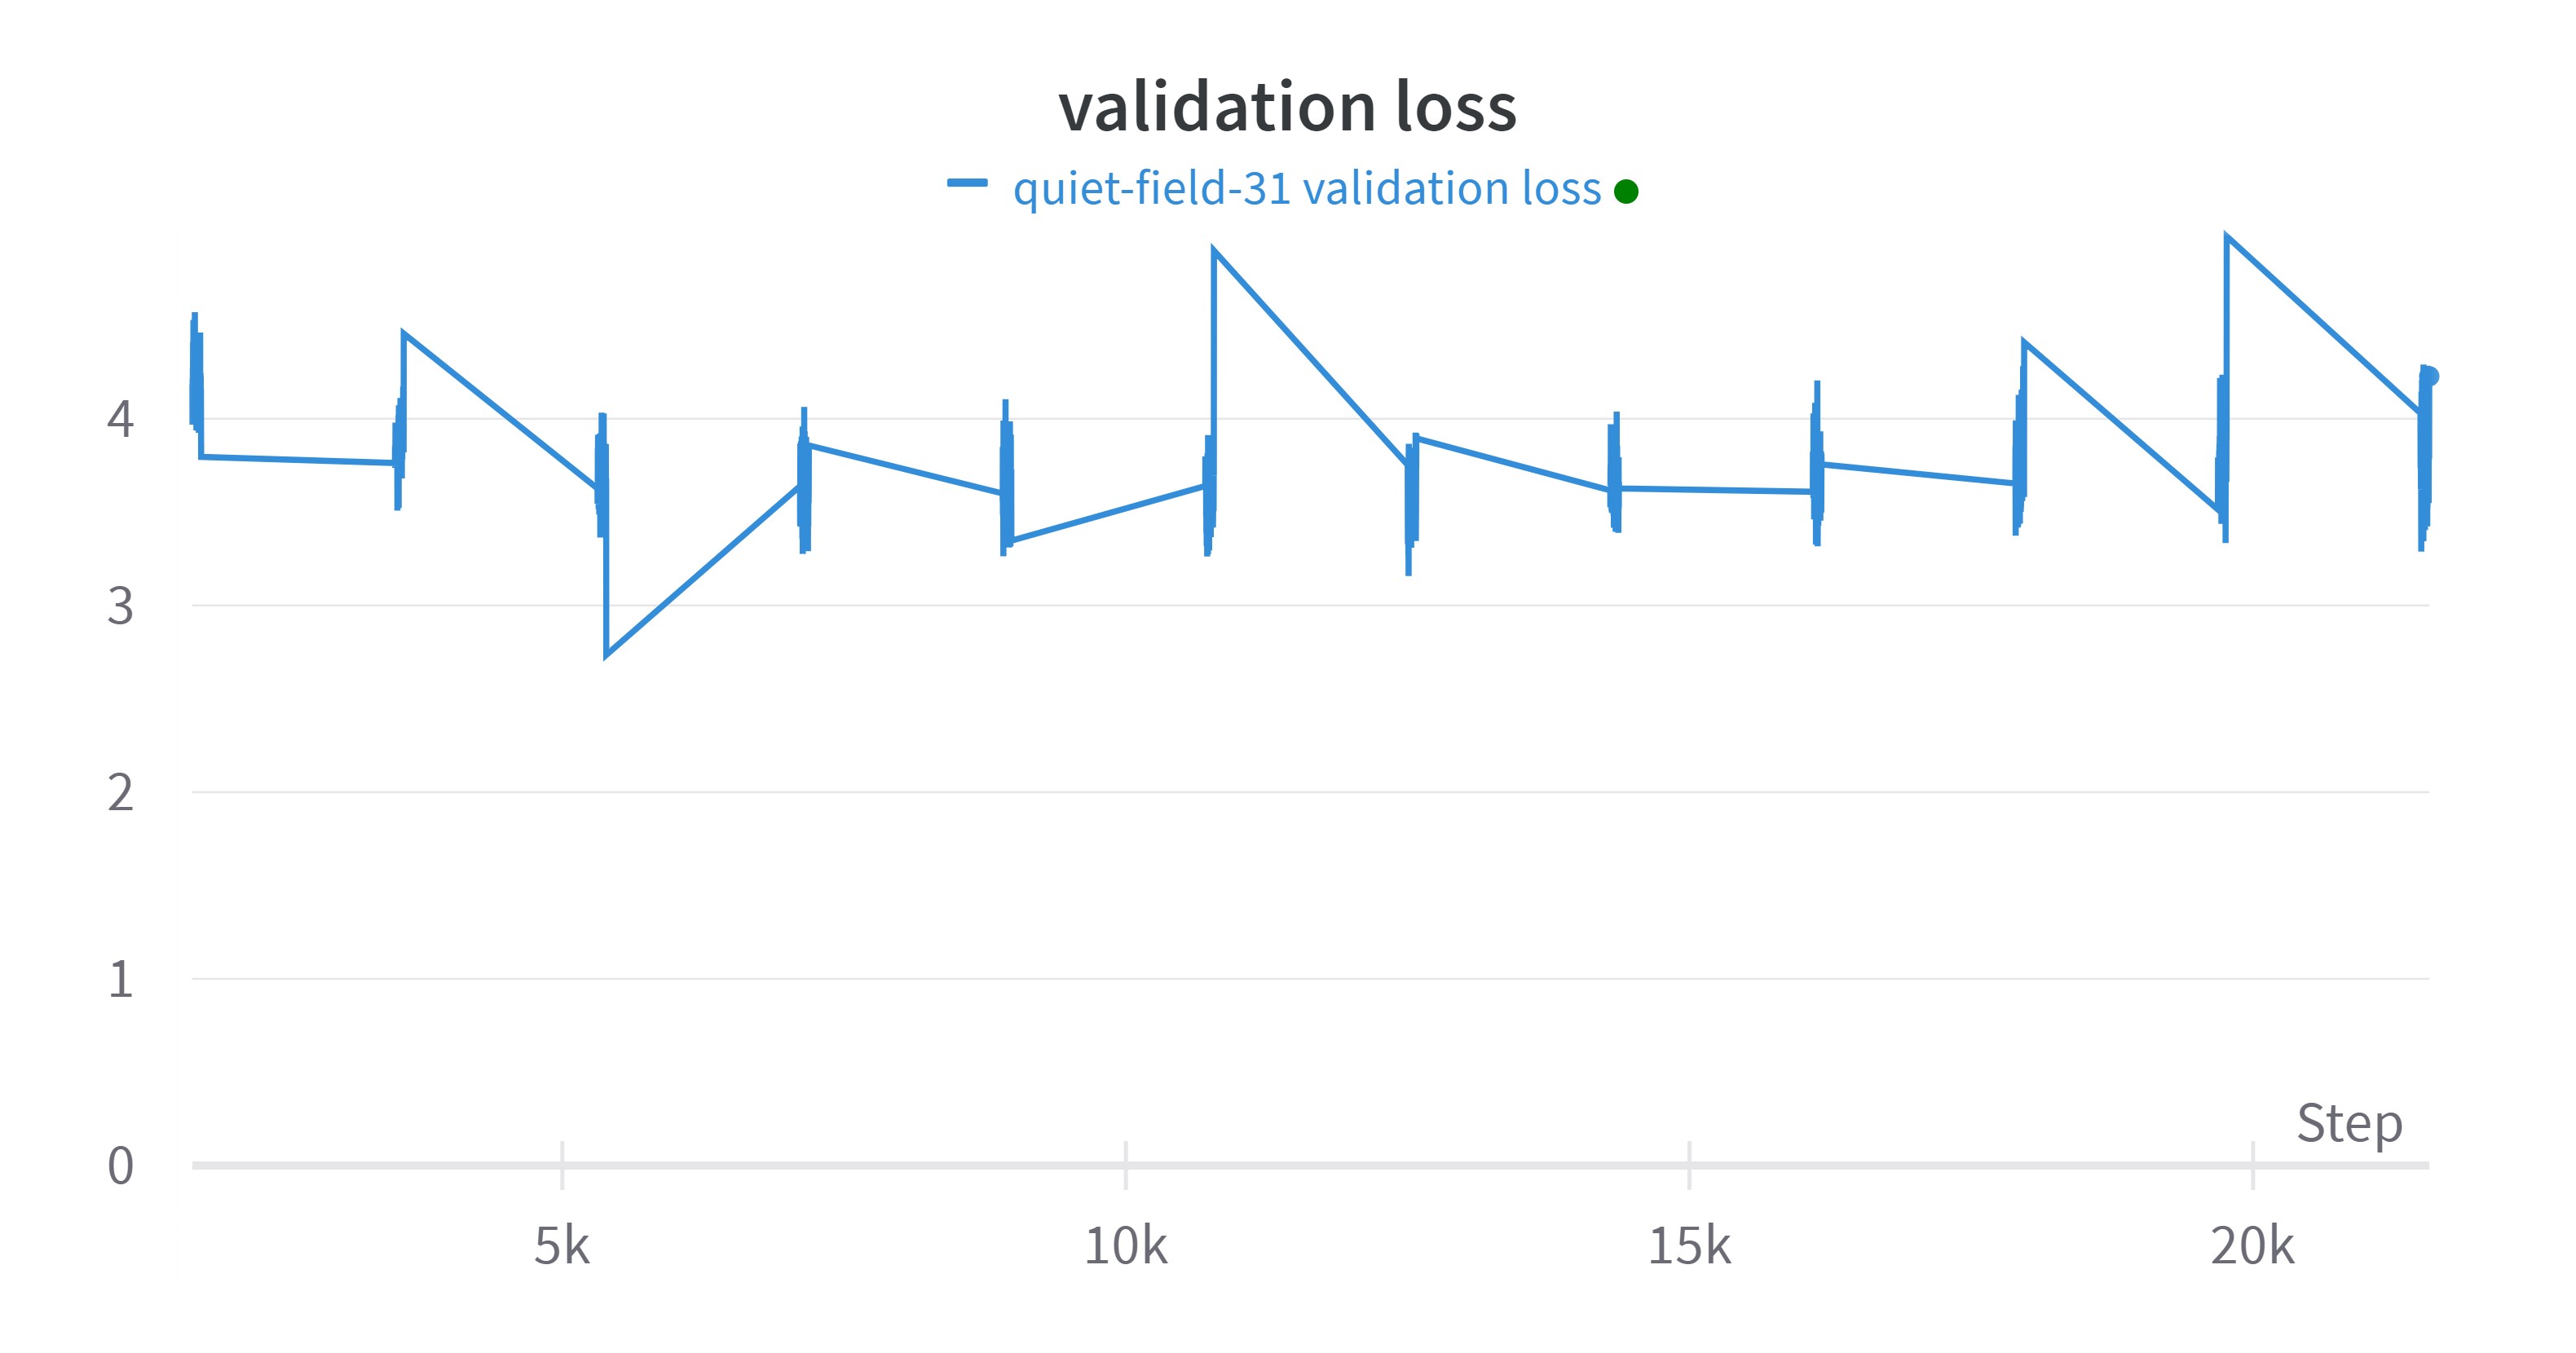

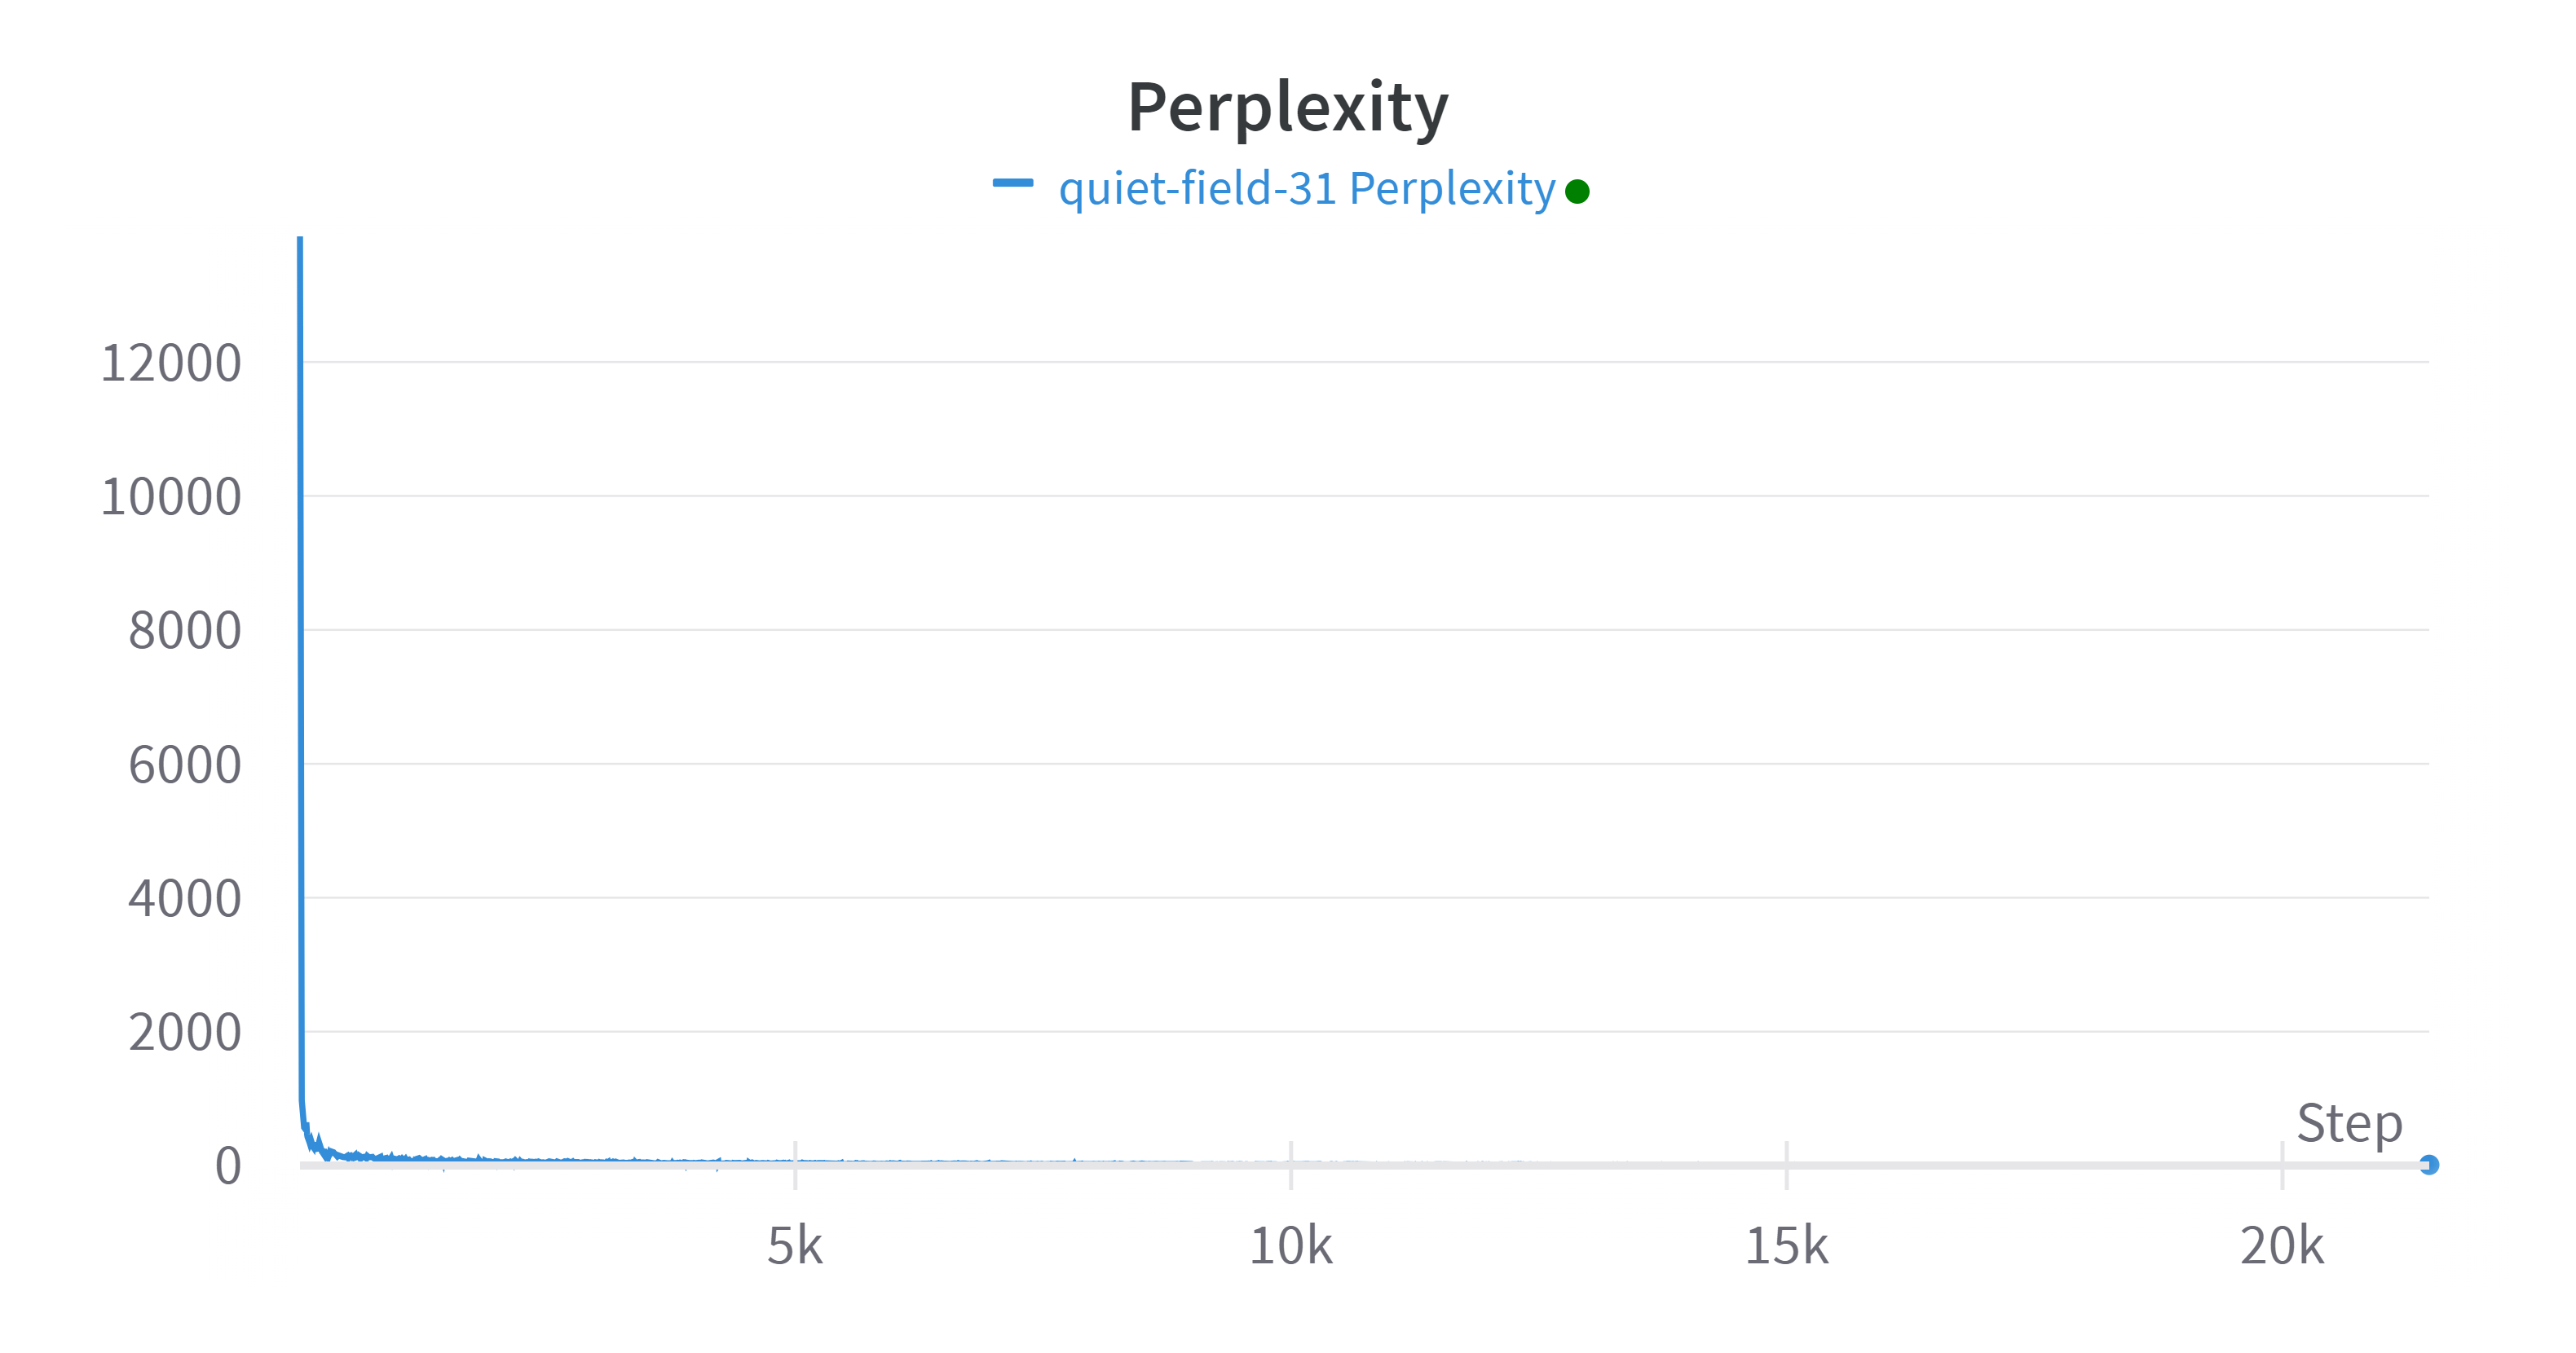

In [6]:
from IPython.display import Image, display
display(Image(filename="training_loss_single.png"))
display(Image(filename="validation_loss_single.png"))
display(Image(filename="perplexity_single.png"))


In [35]:
# Inference 

import torch
import pickle
from torchvision import transforms
from ipynb.fs.full.vocabulary_builder import Vocabulary
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize((224, 224), Image.LANCZOS)

    if transform is not None:
        image = transform(image).unsqueeze(0)

    return image


def main(
    image = 'selected_dataset-60000/test/radiology/images/PMC5525509_JOVR-12-351-g002.jpg',
    encoder_path = 'models/encoder-best.ckpt',
    decoder_path = 'models/decoder-best.ckpt',
    vocab_path = 'vocab_60000.pkl',
    embed_size = 512,
    hidden_size = 256,
    num_layers = 1
):
    # Image preprocessing
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))])

    # Load vocabulary wrapper
    with open(vocab_path, 'rb') as f:
        vocab = pickle.load(f)

    if torch.cuda.is_available():
        map_location = torch.device('cuda')
    else:
        map_location = torch.device('cpu')

    # Build models
    encoder = EncoderCNN(embed_size).eval()  # eval mode (batchnorm uses moving mean/variance)
    decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers, max_seq_length=50)
    encoder = encoder.to(device)
    decoder = decoder.to(device)

    # Load the trained model parameters
    encoder.load_state_dict(torch.load(encoder_path, map_location=map_location))
    decoder.load_state_dict(torch.load(decoder_path, map_location=map_location))

    # Prepare an image
    image = load_image(image, transform)
    image_tensor = image.to(device)

    # Generate an caption from the image
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()  # (1, max_seq_length) -> (max_seq_length)

    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)

    return sentence


            

<start> chest x-ray showing a large mass in the right lung . <end>


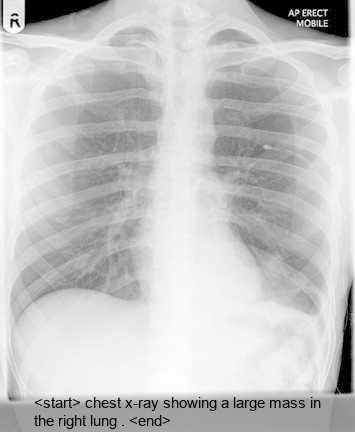

<start> fluoroscopic image of the <unk> ureterorenoscopy . the arrow indicates the tip of the catheter tip in the left atrium . <end>


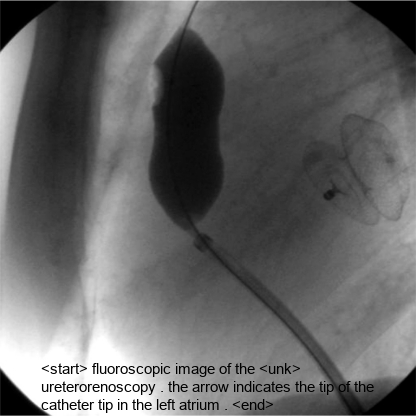

<start> chest x-ray showing a large mass in the right upper lung field . <end>


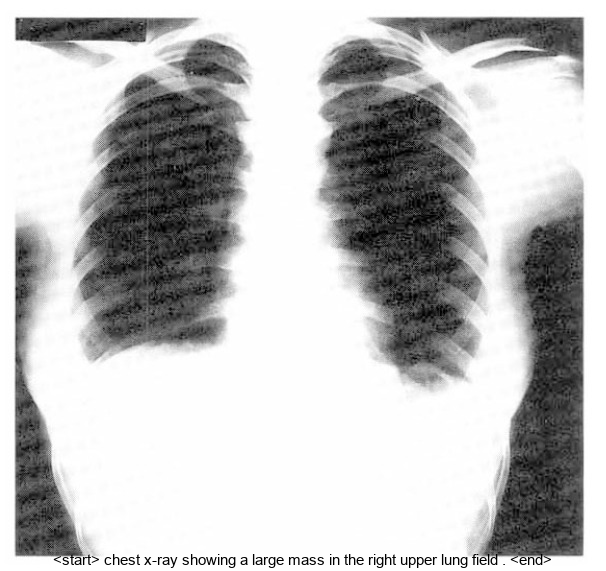

In [36]:
from PIL import Image as PILImage
from PIL import ImageDraw, ImageFont
import textwrap
    
def save_image_with_caption(image_path, caption, save_path, font_path='Arial.ttf'):
    try:
        image = PILImage.open(image_path)
        draw = ImageDraw.Draw(image)

        font = ImageFont.truetype(font_path, 15)

        margin = 6
        max_width = image.width - 2 * margin
        factor = 340/45
        wrapped_text = textwrap.fill(text=caption, width=max_width/factor)  # Adjust wrapping to your needs
        
        # Calculate text size and position
        text_size = draw.multiline_textsize(wrapped_text, font=font)
        text_x = (image.width - text_size[0]) / 2
        text_y = image.height - text_size[1] - margin

        # Draw the text on the image
        draw.multiline_text((text_x, text_y), wrapped_text, font=font, fill="black")

        image.save(save_path)
        image.show()
    except Exception as e:
        print(f"ERR: {e}")
        
images = [
    'selected_dataset-60000/test/radiology/images/PMC3920375_gr4.jpg',
    'selected_dataset-60000/test/radiology/images/PMC3302714_AMS-6-6-976_F3.jpg',
    'selected_dataset-60000/test/radiology/images/PMC4532002_kjim-11-1-87-11f2.jpg'
]
encoder_path = 'models/EX1/encoder-best.ckpt'
decoder_path = 'models/EX1/decoder-best.ckpt'
vocab_path = 'vocab_60000.pkl'
embed_size = 256
hidden_size = 512
num_layers = 1

for image in images:    
    caption = main(image, encoder_path, decoder_path, vocab_path, embed_size, hidden_size, num_layers)
    print(caption)
    out_path = "predicted" + image.split("/")[-1]
    save_image_with_caption(image, caption, out_path)